In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import integrate, signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [10]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [11]:
def get_responsive_pvalue(spike_times, spike_clusters, unit_ids, events, response_window=[0.002, 0.1], apply_mc_corr=True):
    wstat = np.zeros(len(unit_ids), dtype=float) * np.nan
    pvals = np.zeros(len(unit_ids), dtype=float) * np.nan
    spcounts = np.zeros(len(unit_ids), dtype=float) * np.nan
    
    for indi, uniti in enumerate(unit_ids):
        spikesi = np.squeeze(spike_times[spike_clusters == uniti])

        pre_spcounts = np.zeros(len(events), dtype=int)
        post_spcounts = np.zeros(len(events), dtype=int)
        for j, E in enumerate(events):
            pre_spcounts[j] = np.sum((spikesi >= E-response_window[1]) & (spikesi <= E-response_window[0]))
            post_spcounts[j] = np.sum((spikesi >= E+response_window[0]) & (spikesi <= E+response_window[1]))
        
#         if (post_spcounts - pre_spcounts).any():
            # stats.wilcoxon tests whether the differences x-y is symmetric about zero #
        wstat[indi], pvals[indi] = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
            # added zero-method as zsplit because many of the units have too few non-zero samples #
            # this includes the zeros in ranking, but splits them evenly between positive and negative difference ranks #
        spcounts[indi] = np.mean(post_spcounts) - np.mean(pre_spcounts)
        
    if apply_mc_corr:
#         print('Applying multiple comparisons correction...')
        rej, pvals = multitest.fdrcorrection(pvals) #, alpha=0.01) # default alpha=0.05

    return pvals, spcounts

### Define data path

In [12]:
rec_folder = r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

comp_states = {
    'MOs_1200': {'awake': [0], 'anesthetized': [1]},
}

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.


In [13]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
figsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\pop_timing'
if not os.path.exists(figsavedir):
    os.mkdir(figsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim_vis


#### Load stim table and speed signal

In [14]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,30,313.21234,313.21274,0.0004,0,True
1,biphasic,10,317.12436,317.12476,0.0004,0,True
2,biphasic,10,321.22743,321.22783,0.0004,0,True
3,biphasic,50,325.47838,325.47878,0.0004,0,True
4,biphasic,50,329.56234,329.56274,0.0004,0,True


In [15]:
run_signal, run_timestamps = exp.load_running()

In [16]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
        
## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(currents_list)
print(PCI_stim_amp)

['10', '30', '50']
30


#### Load unit data

In [17]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeF']


In [18]:
probe_unit_data = {}
probe_LFP_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    probe_LFP_data[probei] = {}
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Get saline chs for re-ref ##
    if surface_ch + 25 > 384:
        probe_LFP_data[probei]['saline_chs'] = np.arange(383, 378, -1)
    else:
        probe_LFP_data[probei]['saline_chs'] = np.arange(surface_ch + 15, surface_ch + 25)
    if 'area_ch' in data.keys():
        probe_LFP_data[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_LFP_data[probei]['pop_chs'] = {key: [] for key in list(areas_of_interest.keys())}
        probe_LFP_data[probei]['pop_ch_depths'] = {key: [] for key in list(areas_of_interest.keys())}
        for chind in npx_allch:
            parent_region = [
                k for k in list(areas_of_interest.keys()) if probe_LFP_data[probei]['ch_areas'][chind] in areas_of_interest[k]
            ]
            if len(parent_region) == 1:
                probe_LFP_data[probei]['pop_chs'][parent_region[0]].append(chind)
                probe_LFP_data[probei]['pop_ch_depths'][parent_region[0]].append(probe_unit_data[probei]['ch_depths'][chind])
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['units'] = all_units
    probe_unit_data[probei]['chs'] = all_units_chs
    probe_unit_data[probei]['cell_type'] = all_units_types
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['areas'] = all_units_areas
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 370
 unit count: 331
probeF
 surface channel: 275
 unit count: 276
Total unit count: 607


In [19]:
probe_popspiketimes = {key: [] for key in list(areas_of_interest.keys())}
for probei, unit_data in probe_unit_data.items():
    ## Get trial spikes for each unit ##
    for unitind, uniti in enumerate(unit_data['units']):
        spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
        parent_region = [key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]]
        if len(parent_region) == 1:
            probe_popspiketimes[parent_region[0]].append(spikesi)

pop_spikes = {}
for region in probe_popspiketimes.keys():
    print('{}: {:d} units'.format(region, len(probe_popspiketimes[region])))
    if len(probe_popspiketimes[region]) != 0:
        pop_spikes[region] = {}
        pop_spikes[region]['units'] = len(probe_popspiketimes[region])
        pop_spikes[region]['spike_times'] = np.concatenate(probe_popspiketimes[region])
del probe_popspiketimes

MO: 89 units
ACA: 136 units
SS: 76 units
VIS: 0 units
MO-TH: 120 units


## Get trial times

In [20]:
rest_trials_only = True
all_event_times = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    for parami in currents_list:
        print('biphasic - {} \u03bcA'.format(parami))
        all_event_times[expdes][parami] = {}
        for statei, sweeps in state_sweeps.items():
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

            if rest_trials_only:
                all_event_times[expdes][parami][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][parami][statei] = state_events

MOs_1200
biphasic - 10 μA
 awake state: resting trials 85/120
 anesthetized state: resting trials 120/120
biphasic - 30 μA
 awake state: resting trials 96/120
 anesthetized state: resting trials 120/120
biphasic - 50 μA
 awake state: resting trials 96/120
 anesthetized state: resting trials 120/120


### Categorize responsive units

In [21]:
raster_window = [-1.0, 1.0]
alpha = 0.05

integrate_window = [0.0, 0.025]
zthresh = 3 # pop firing rate must exceed mean(baselineFR) + zthresh*std(baselineFR)

time_bin = 0.0001 # size of time bins (s)
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2
sigshort = 5 # Gaussian kernel length (Butovas&Schwarz2003 use short kernel for first excitatory response)
siglong = 50 # Gaussian kernel length (Butovas&Schwarz2003 use long kernel for rest of response)

In [27]:
pop_all_SDF = {}
pop_response_metrics = {}
for expdes in all_event_times.keys():
    print('{}'.format(expdes))
    pop_all_SDF[expdes] = {}
    pop_response_metrics[expdes] = {}
    for parami, statesevents in all_event_times[expdes].items():
        pop_all_SDF[expdes][parami] = {}
        pop_response_metrics[expdes][parami] = {}
        for statei, events in statesevents.items():
            print(' {} \u03bcA - {}'.format(parami, statei))
            pop_all_SDF[expdes][parami][statei] = {}
            pop_response_metrics[expdes][parami][statei] = {}
            ## Loop through regions to get event-related population spikes ##
            for region in pop_spikes.keys():
                pop_all_SDF[expdes][parami][statei][region] = {}
                SDF_short = np.zeros((len(events), len(timex)), dtype=float)
                SDF_long = np.zeros((len(events), len(timex)), dtype=float)
                region_spikes = pop_spikes[region]['spike_times']
                trial_response = np.zeros((len(events)), dtype=bool)
                response_start = np.zeros((len(events)), dtype=float)
                peak_FR = np.zeros((len(events)), dtype=float)
                peak_time = np.zeros((len(events)), dtype=float)
                response_mag = np.zeros((len(events)), dtype=float)
                for ii, (eventi) in enumerate(events):
                    spikeinds = np.squeeze(
                        np.argwhere((region_spikes > eventi + raster_window[0]) & (region_spikes < eventi + raster_window[1]))
                    )
                    spcounts, edges = np.histogram(region_spikes[spikeinds] - eventi, bins)
                    SDF_short[ii] = (
                        ndimage.gaussian_filter(spcounts, sigma=sigshort, output=float)/(time_bin*pop_spikes[region]['units']))
                    SDF_long[ii] = (
                        ndimage.gaussian_filter(spcounts, sigma=siglong, output=float)/(time_bin*pop_spikes[region]['units']))
                    
                    ## Evaluate peak SDF for each trial ##
                    popSDF = SDF_short[ii]
                    intinds = np.nonzero((timex >= integrate_window[0]) & (timex <= integrate_window[1]))[0]
                    FRthresh = np.mean(popSDF[timex < 0]) + zthresh * np.std(popSDF[timex < 0])

                    peaks, props = signal.find_peaks(popSDF[intinds], height=FRthresh)
                    if len(peaks) > 0:
                        trial_response[ii] = True
                        ## Find threshold crossing time ##
                        response_start[ii] = timex[intinds[np.argwhere(popSDF[intinds] > FRthresh)[0][0]]]
                        ## Find peak value and time ##
#                         peaks, props = signal.find_peaks(popSDF[intinds], height=FRthresh)
                        maxind = np.argmax(popSDF[intinds[peaks]])
                        peak_time[ii] = timex[intinds[peaks[maxind]]]
                        peak_FR[ii] = popSDF[intinds[peaks[maxind]]]
                        ## Measure AUC of popFR above FRthresh ##
                        SDF_over_thresh = np.where((popSDF - FRthresh) < 0, 0.0, (popSDF - FRthresh))
                        response_mag[ii] = integrate.simps(SDF_over_thresh[intinds], timex[intinds], axis=0, even='last')
                    else:
                        trial_response[ii] = False
                        response_start[ii] = np.nan
                        peak_time[ii] = np.nan
                        peak_FR[ii] = np.nan
                        response_mag[ii] = np.nan
                    
                    
                pop_all_SDF[expdes][parami][statei][region]['short'] = [timex, SDF_short]
                pop_all_SDF[expdes][parami][statei][region]['long'] = [timex, SDF_long]
                pop_response_metrics[expdes][parami][statei][region] = pd.DataFrame({
                    'trial': np.arange(len(events)),
                    'response': trial_response,
                    'response_latency': response_start,
                    'response_peak_latency': peak_time,
                    'peak_firing_rate': peak_FR,
                    'response_magnitude': response_mag,
                })

MOs_1200
 10 μA - awake
 10 μA - anesthetized
 30 μA - awake
 30 μA - anesthetized
 50 μA - awake
 50 μA - anesthetized


### Plot the metrics

In [56]:
test_states = ['awake', 'anesthetized']
barlocs = np.arange((len(currents_list) * len(test_states) + 1) * len(pop_spikes.keys()))
barlocs = barlocs.reshape((len(pop_spikes.keys()), (len(currents_list) * len(test_states) + 1)))

barcolors = ['lightblue', 'dodgerblue', 'blue']
state_hatch = [None, 'xxx']

plexp = 'MOs_1200'

#### Response fidelity

<IPython.core.display.Javascript object>


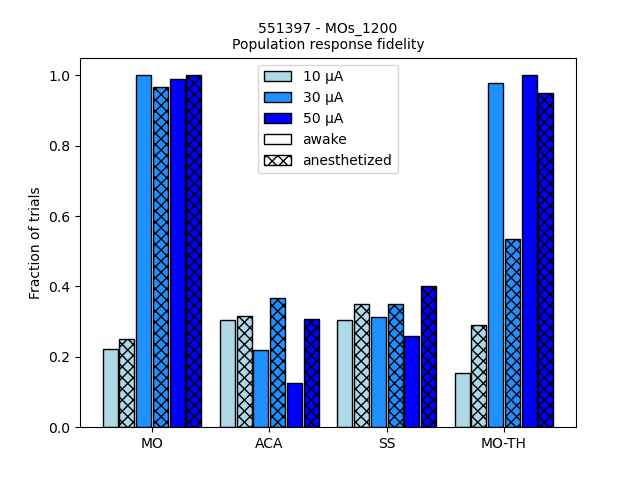

In [60]:
fig, ax = plt.subplots()
for ri, (region) in enumerate(pop_spikes.keys()):
    for ii, (parami, paramdict) in enumerate(pop_response_metrics[plexp].items()):
        for jj, (statei, statedict) in enumerate(pop_response_metrics[plexp][parami].items()):
            trials_wresp = statedict[region].response.values
            fraction_resp = np.sum(trials_wresp) / len(trials_wresp)
            xloc = barlocs[ri, 2*ii+jj]
            ax.bar(xloc, fraction_resp, width=0.9, color=barcolors[ii], edgecolor='k', hatch=state_hatch[jj])
            
ax.set_title('{} - {}\nPopulation response fidelity'.format(exp.mouse, plexp))
ax.set_ylabel('Fraction of trials')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(pop_spikes.keys())

## Make a legend ##
mhandles = []
for ii, parami in enumerate(currents_list):
    mhandles.append(Patch(color=barcolors[ii], ec='k', label='{} \u03bcA'.format(parami)))
for jj, statei in enumerate(test_states):
    mhandles.append(Patch(color='w', ec='k', hatch=state_hatch[jj], label=statei))
ax.legend(handles=mhandles)

## Save ##
figname = '{}_pop_response_fidelity.png'.format(plexp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

#### Response start time

<IPython.core.display.Javascript object>


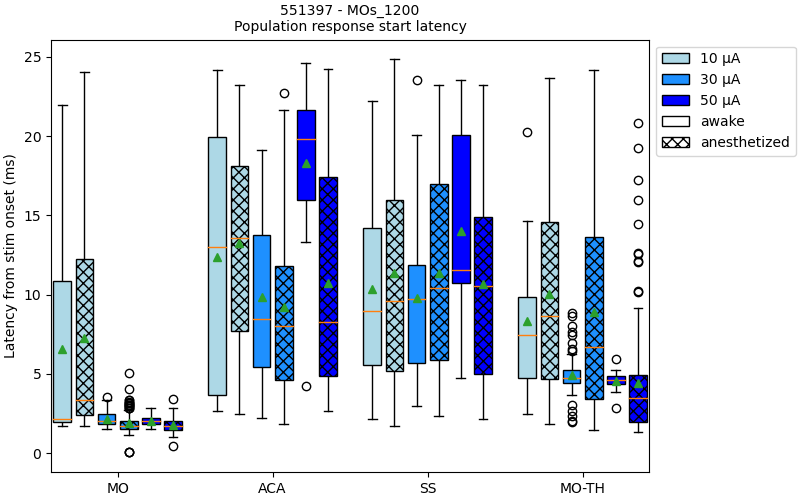

In [86]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
for ri, (region) in enumerate(pop_spikes.keys()):
    for ii, (parami, paramdict) in enumerate(pop_response_metrics[plexp].items()):
        for jj, (statei, statedict) in enumerate(pop_response_metrics[plexp][parami].items()):
            response_latency = statedict[region].response_latency.values
            mask = ~np.isnan(response_latency)
            xloc = barlocs[ri, 2*ii+jj]
#             ax.boxplot(xloc, response_latency*1E3, widths=0.9, color=barcolors[ii], edgecolor='k', hatch=state_hatch[jj])
            bbox = ax.boxplot(response_latency[mask]*1E3, positions=[xloc], widths=0.8, patch_artist=True, showmeans=True)
            plt.setp(bbox['boxes'], facecolor=barcolors[ii], hatch=state_hatch[jj])
            
ax.set_title('{} - {}\nPopulation response start latency'.format(exp.mouse, plexp))
ax.set_ylabel('Latency from stim onset (ms)')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(pop_spikes.keys())

## Make a legend ##
mhandles = []
for ii, parami in enumerate(currents_list):
    mhandles.append(Patch(color=barcolors[ii], ec='k', label='{} \u03bcA'.format(parami)))
for jj, statei in enumerate(test_states):
    mhandles.append(Patch(color='w', ec='k', hatch=state_hatch[jj], label=statei))
ax.legend(handles=mhandles, loc='upper left', bbox_to_anchor=(1, 1))

## Save ##
figname = '{}_pop_response_startlatency.png'.format(plexp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

#### Peak firing rate

<IPython.core.display.Javascript object>


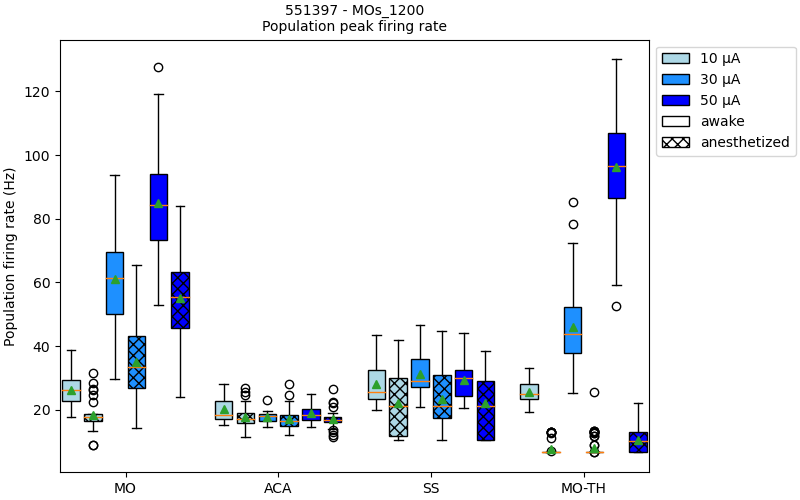

In [89]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
for ri, (region) in enumerate(pop_spikes.keys()):
    for ii, (parami, paramdict) in enumerate(pop_response_metrics[plexp].items()):
        for jj, (statei, statedict) in enumerate(pop_response_metrics[plexp][parami].items()):
            peakFR = statedict[region].peak_firing_rate.values
            mask = ~np.isnan(peakFR)
            xloc = barlocs[ri, 2*ii+jj]
            bbox = ax.boxplot(peakFR[mask], positions=[xloc], widths=0.8, patch_artist=True, showmeans=True)
            plt.setp(bbox['boxes'], facecolor=barcolors[ii], hatch=state_hatch[jj])
            
ax.set_title('{} - {}\nPopulation peak firing rate'.format(exp.mouse, plexp))
ax.set_ylabel('Population firing rate (Hz)')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(pop_spikes.keys())

## Make a legend ##
mhandles = []
for ii, parami in enumerate(currents_list):
    mhandles.append(Patch(color=barcolors[ii], ec='k', label='{} \u03bcA'.format(parami)))
for jj, statei in enumerate(test_states):
    mhandles.append(Patch(color='w', ec='k', hatch=state_hatch[jj], label=statei))
ax.legend(handles=mhandles, loc='upper left', bbox_to_anchor=(1, 1))

## Save ##
figname = '{}_pop_peak_response.png'.format(plexp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

#### Response peak time

<IPython.core.display.Javascript object>


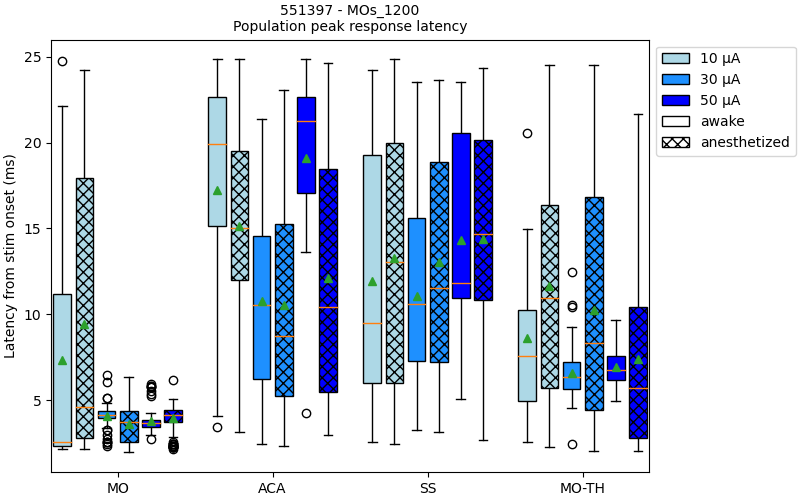

In [91]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
for ri, (region) in enumerate(pop_spikes.keys()):
    for ii, (parami, paramdict) in enumerate(pop_response_metrics[plexp].items()):
        for jj, (statei, statedict) in enumerate(pop_response_metrics[plexp][parami].items()):
            peak_latency = statedict[region].response_peak_latency.values
            mask = ~np.isnan(peak_latency)
            xloc = barlocs[ri, 2*ii+jj]
            bbox = ax.boxplot(peak_latency[mask]*1E3, positions=[xloc], widths=0.8, patch_artist=True, showmeans=True)
            plt.setp(bbox['boxes'], facecolor=barcolors[ii], hatch=state_hatch[jj])
            
ax.set_title('{} - {}\nPopulation peak response latency'.format(exp.mouse, plexp))
ax.set_ylabel('Latency from stim onset (ms)')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(pop_spikes.keys())

## Make a legend ##
mhandles = []
for ii, parami in enumerate(currents_list):
    mhandles.append(Patch(color=barcolors[ii], ec='k', label='{} \u03bcA'.format(parami)))
for jj, statei in enumerate(test_states):
    mhandles.append(Patch(color='w', ec='k', hatch=state_hatch[jj], label=statei))
ax.legend(handles=mhandles, loc='upper left', bbox_to_anchor=(1, 1))

## Save ##
figname = '{}_pop_response_peaklatency.png'.format(plexp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

#### Response magnitude

<IPython.core.display.Javascript object>


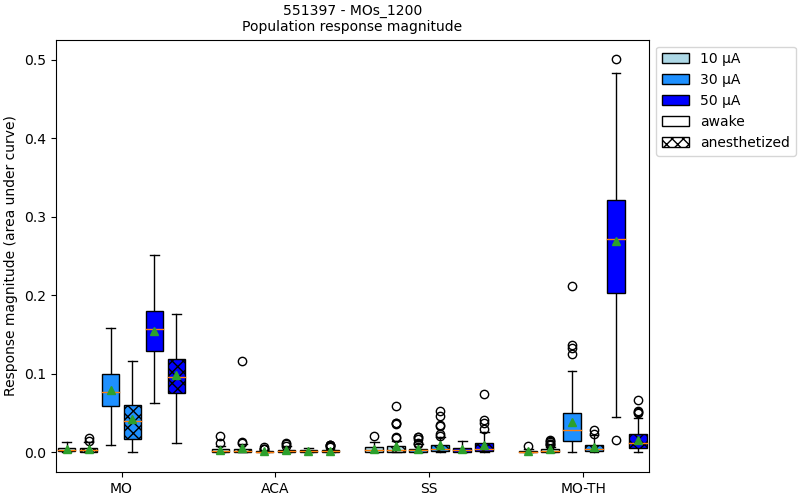

In [93]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
for ri, (region) in enumerate(pop_spikes.keys()):
    for ii, (parami, paramdict) in enumerate(pop_response_metrics[plexp].items()):
        for jj, (statei, statedict) in enumerate(pop_response_metrics[plexp][parami].items()):
            auc = statedict[region].response_magnitude.values
            mask = ~np.isnan(auc)
            xloc = barlocs[ri, 2*ii+jj]
            bbox = ax.boxplot(auc[mask], positions=[xloc], widths=0.8, patch_artist=True, showmeans=True)
            plt.setp(bbox['boxes'], facecolor=barcolors[ii], hatch=state_hatch[jj])
            
ax.set_title('{} - {}\nPopulation response magnitude'.format(exp.mouse, plexp))
ax.set_ylabel('Response magnitude (area under curve)')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(pop_spikes.keys())

## Make a legend ##
mhandles = []
for ii, parami in enumerate(currents_list):
    mhandles.append(Patch(color=barcolors[ii], ec='k', label='{} \u03bcA'.format(parami)))
for jj, statei in enumerate(test_states):
    mhandles.append(Patch(color='w', ec='k', hatch=state_hatch[jj], label=statei))
ax.legend(handles=mhandles, loc='upper left', bbox_to_anchor=(1, 1))

## Save ##
figname = '{}_pop_response_mag-auc.png'.format(plexp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

### Exploring trial-by-trial correlations

<IPython.core.display.Javascript object>


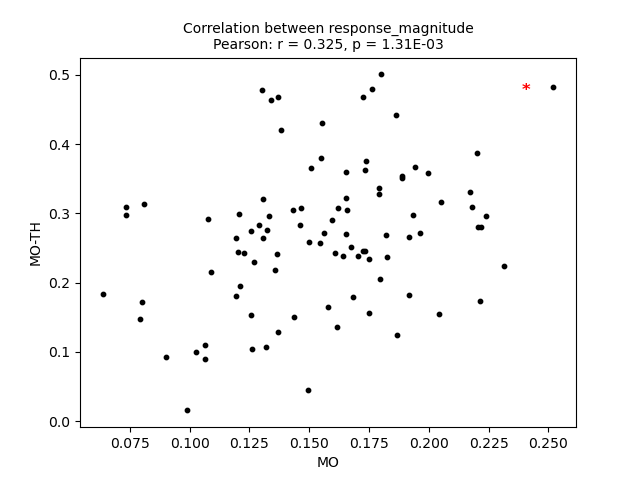

In [131]:
reg1 = 'MO'
reg2 = 'MO-TH'
comp_metric = 'response_magnitude' # choose: 'response_latency', 'peak_firing_rate', 'response_peak_latency', 'response_magnitude'

plamp = '50'
plstate = 'awake' # choose: 'awake'

vals_reg1 = pop_response_metrics[plexp][plamp][plstate][reg1][comp_metric].values
vals_reg2 = pop_response_metrics[plexp][plamp][plstate][reg2][comp_metric].values

mask = ~np.isnan(vals_reg1) & ~np.isnan(vals_reg2)
pearson_r, pearson_p = stats.pearsonr(vals_reg1[mask], vals_reg2[mask])
minx = np.min(vals_reg1)
maxx = np.max(vals_reg1)

fig, ax = plt.subplots()
ax.scatter(vals_reg1[mask], vals_reg2[mask], c='k', s=10)
ax.set_xlabel(reg1)
ax.set_ylabel(reg2)
# ax.plot([minx, maxx], [minx, maxx], linestyle='dashed', color='k', linewidth=1)
ax.set_title('Correlation between {}\nPearson: r = {:.3f}, p = {:.2E}'.format(comp_metric, pearson_r, pearson_p))
if pearson_p < alpha:
    ax.annotate('*', xy=(0.9, 0.9), xycoords='axes fraction', color='r', fontsize=12, fontweight='bold', ha='center')

### Relative response magnitudes

In [129]:
otherROI = list(pop_spikes.keys())
reg1 = 'MO'
otherROI.remove(reg1)
print(otherROI)

relbarlocs = np.arange((len(currents_list) * len(test_states) + 1) * len(otherROI))
relbarlocs = relbarlocs.reshape((len(otherROI), (len(currents_list) * len(test_states) + 1)))

['ACA', 'SS', 'MO-TH']


<IPython.core.display.Javascript object>


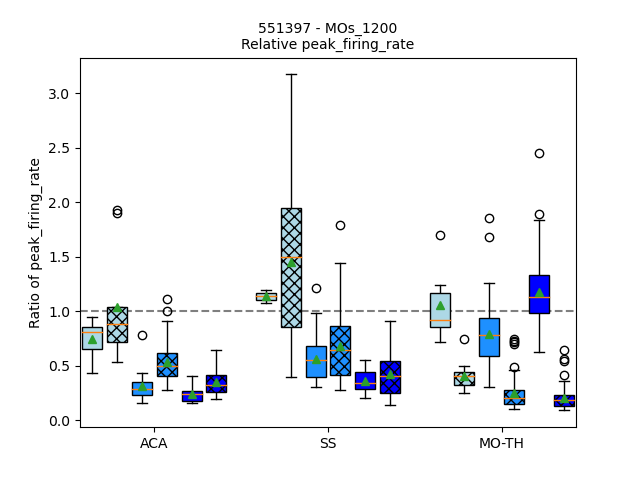

[Text(2.5, 0, 'ACA'), Text(9.5, 0, 'SS'), Text(16.5, 0, 'MO-TH')]

In [137]:
comp_metric = 'peak_firing_rate' # choose: 'response_latency', 'peak_firing_rate', 'response_peak_latency', 'response_magnitude'

fig, ax = plt.subplots()
for ii, (parami, paramdict) in enumerate(pop_response_metrics[plexp].items()):
    for jj, (statei, statedict) in enumerate(pop_response_metrics[plexp][parami].items()):
        print('{} \u03bcA - {}'.format(parami, statei))
        vals_reg1 = pop_response_metrics[plexp][parami][statei][reg1][comp_metric].values
        for ri, (reg2) in enumerate(otherROI):
            vals_reg2 = pop_response_metrics[plexp][parami][statei][reg2][comp_metric].values
            mask = ~np.isnan(vals_reg1) & ~np.isnan(vals_reg2)
            ratio = vals_reg2[mask] / vals_reg1[mask]
            print(' {}-{}: {:d} trials'.format())
            xloc = barlocs[ri, 2*ii+jj]
            bbox = ax.boxplot(ratio, positions=[xloc], widths=0.8, patch_artist=True, showmeans=True)
            plt.setp(bbox['boxes'], facecolor=barcolors[ii], hatch=state_hatch[jj])

ax.axhline(1, color='k', linestyle='dashed', alpha=0.5)
ax.set_title('{} - {}\nRelative {}'.format(exp.mouse, plexp, comp_metric))
ax.set_ylabel('Ratio of {}'.format(comp_metric))
ax.set_xticks(np.mean(relbarlocs[:,:-1], axis=1))
ax.set_xticklabels(otherROI)